In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,Dataset
from torchvision.utils import make_grid
from torchvision import datasets,transforms
import os
from IPython.display import display
from PIL import Image
device = torch.device("mps")

In [3]:
#rock paper scissors classification
root = '/Users/aadityajoshi/Downloads/archive-15/rps/rps'
test_root = '/Users/aadityajoshi/Downloads/archive-15/rps-test-set/rps-test-set'

In [4]:
img_names = []
for folder,subfolder,filenames in os.walk(root):
    for img in filenames:
        img_names.append(folder+'/'+img)

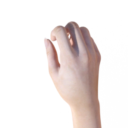

In [5]:
with Image.open('/Users/aadityajoshi/Downloads/archive-15/rps/rps/rock/rock01-047.png') as img:
    centr_trn = transforms.CenterCrop(128)
    resize = transforms.Resize((128,128))
    img = resize(img)
    img = centr_trn(img)
    display(img)

In [6]:
img_sizes = []
rejected = []

for item in img_names:
    try : 
        with Image.open(item) as img:
            img_sizes.append(img.size)
    except:
        rejected.append(item)
df = pd.DataFrame(img_sizes)

In [7]:
rejected

[]

In [8]:
df.describe()

,0,1
count,2520.0,2520.0
mean,300.0,300.0
std,0.0,0.0
min,300.0,300.0
25%,300.0,300.0
50%,300.0,300.0
75%,300.0,300.0
max,300.0,300.0


In [55]:
train_transform = transforms.Compose([
            transforms.Resize(128),
            transforms.CenterCrop(128),
            transforms.RandomHorizontalFlip(0.2),
            transforms.RandomRotation(10),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485,0.456,0.406],std=[0.229,0.224,0.225])])

In [56]:
test_transform = transforms.Compose([
            transforms.Resize(128),
            transforms.CenterCrop(128),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485,0.456,0.406],std=[0.229,0.224,0.225])])

In [57]:
train_dataset = datasets.ImageFolder(root,train_transform)

In [12]:
train_dataset

Dataset ImageFolder
    Number of datapoints: 2520
    Root location: /Users/aadityajoshi/Downloads/archive-15/rps/rps
    StandardTransform
Transform: Compose(
               Resize(size=128, interpolation=bilinear, max_size=None, antialias=True)
               CenterCrop(size=(128, 128))
               RandomHorizontalFlip(p=0.2)
               RandomRotation(degrees=[-50.0, 50.0], interpolation=nearest, expand=False, fill=0)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

In [58]:
class_names = train_dataset.classes
print(class_names)

['paper', 'rock', 'scissors']


In [59]:
test_dataset = datasets.ImageFolder(test_root,test_transform)

In [15]:
test_dataset

Dataset ImageFolder
    Number of datapoints: 372
    Root location: /Users/aadityajoshi/Downloads/archive-15/rps-test-set/rps-test-set
    StandardTransform
Transform: Compose(
               Resize(size=128, interpolation=bilinear, max_size=None, antialias=True)
               CenterCrop(size=(128, 128))
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

In [60]:
class_test = test_dataset.classes

In [17]:
class_test

['paper', 'rock', 'scissors']

In [61]:
train_batch_size = 128
test_batch_size = 512
train_loader = DataLoader(train_dataset,train_batch_size,shuffle=True)
test_loader = DataLoader(test_dataset,test_batch_size,shuffle=False)

In [62]:
for x,y in train_loader:
    break

In [63]:
x.size()

torch.Size([128, 3, 128, 128])

In [21]:
y.size()

torch.Size([128])

In [64]:
def dim_calc(n_in,w_in,h_in,f,s,p,num_filters,max_pool,ms,mf):
    #(height,widht)
    if type(s) == tuple: #(2,1)
        s_h = s[0]
        s_w = s[1]
    else:
        s_h,s_w = s,s
    if type(f) == tuple:
        f_h = f[0]
        f_w = f[1]
    else:
        f_h,f_w = f,f
    if type(p) == tuple:
        p_h = p[0]
        p_w = p[1]
    else:
        p_h,p_w = p,p
        
    height = ((h_in-f_h+2*p_h)//s_h)+1
    width = ((w_in-f_w+2*p_w)//s_w)+1
    channels = num_filters
    if max_pool == True:
        height = ((height-mf)//ms)+1
        width = ((width-mf)//ms)+1
    return (channels,height,width)

In [70]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet,self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3,out_channels=8,kernel_size=3,stride=1)
        self.conv2 = nn.Conv2d(in_channels=8,out_channels=16,kernel_size=3,stride=1)
        self.conv3 = nn.Conv2d(in_channels=16,out_channels=32,kernel_size=3,stride=1)
        self.fc1 = nn.Linear(32*14*14,128)
        self.fc2 = nn.Linear(128,32)
        self.out = nn.Linear(32,3)
    def forward(self,x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x,2,2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x,2,2)
        x = F.relu(self.conv3(x))
        x = F.max_pool2d(x,2,2)
        x = x.view(-1,32*14*14)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.out(x)
        return F.log_softmax(x,dim=1)

In [75]:
print(f"1:{dim_calc(3,128,128,3,1,0,8,True,2,2)}")
print(f"2:{dim_calc(8,63,63,3,1,0,16,True,2,2)}")


1:(8, 63, 63)
2:(16, 30, 30)


In [76]:
16*30*30

14400

In [71]:
cnn = ConvNet().to(device)

In [72]:
num_epochs = 15
optimizer = torch.optim.Adam(cnn.parameters(),lr=0.001)
criterion = nn.CrossEntropyLoss()

In [73]:
import time
from tqdm import tqdm

start = time.time()
for epoch in range(num_epochs):
    cnn.train()
    # Wrap your train_loader with tqdm
    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")
    total_loss = 0
    for img, label in pbar:
        img, label = img.to(device), label.to(device)
        y_pred = cnn(img)
        loss = criterion(y_pred, label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Update total loss and progress bar
        total_loss += loss.item()
        pbar.set_postfix({'loss': f'{loss.item():.4f}'})
    
    # Calculate and print average loss for the epoch
    avg_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch+1}/{num_epochs}, Average Loss: {avg_loss:.4f}")

print(f"Total training time: {(time.time() - start) / 60:.2f} minutes")

Epoch 1/15: 100%|██████████████████| 20/20 [00:08<00:00,  2.26it/s, loss=0.6180]


Epoch 1/15, Average Loss: 0.9223


Epoch 2/15: 100%|██████████████████| 20/20 [00:08<00:00,  2.47it/s, loss=0.2192]


Epoch 2/15, Average Loss: 0.4277


Epoch 3/15: 100%|██████████████████| 20/20 [00:07<00:00,  2.74it/s, loss=0.1210]


Epoch 3/15, Average Loss: 0.1837


Epoch 4/15: 100%|██████████████████| 20/20 [00:07<00:00,  2.84it/s, loss=0.1734]


Epoch 4/15, Average Loss: 0.1128


Epoch 5/15: 100%|██████████████████| 20/20 [00:07<00:00,  2.65it/s, loss=0.0349]


Epoch 5/15, Average Loss: 0.0662


Epoch 6/15: 100%|██████████████████| 20/20 [00:07<00:00,  2.73it/s, loss=0.0390]


Epoch 6/15, Average Loss: 0.0478


Epoch 7/15: 100%|██████████████████| 20/20 [00:07<00:00,  2.85it/s, loss=0.0133]


Epoch 7/15, Average Loss: 0.0226


Epoch 8/15: 100%|██████████████████| 20/20 [00:07<00:00,  2.85it/s, loss=0.0057]


Epoch 8/15, Average Loss: 0.0163


Epoch 9/15: 100%|██████████████████| 20/20 [00:07<00:00,  2.78it/s, loss=0.0066]


Epoch 9/15, Average Loss: 0.0119


Epoch 10/15: 100%|█████████████████| 20/20 [00:06<00:00,  2.86it/s, loss=0.0042]


Epoch 10/15, Average Loss: 0.0082


Epoch 11/15: 100%|█████████████████| 20/20 [00:07<00:00,  2.85it/s, loss=0.0033]


Epoch 11/15, Average Loss: 0.0068


Epoch 12/15: 100%|█████████████████| 20/20 [00:07<00:00,  2.85it/s, loss=0.0007]


Epoch 12/15, Average Loss: 0.0063


Epoch 13/15: 100%|█████████████████| 20/20 [00:07<00:00,  2.82it/s, loss=0.0034]


Epoch 13/15, Average Loss: 0.0055


Epoch 14/15: 100%|█████████████████| 20/20 [00:07<00:00,  2.85it/s, loss=0.0005]


Epoch 14/15, Average Loss: 0.0030


Epoch 15/15: 100%|█████████████████| 20/20 [00:07<00:00,  2.85it/s, loss=0.0010]

Epoch 15/15, Average Loss: 0.0034
Total training time: 1.83 minutes


In [37]:
from sklearn.metrics import classification_report
all_preds = []
all_labels = []

cnn.eval()
with torch.no_grad():
    for img, label in test_loader:
        img, label = img.to(device), label.to(device)
        pred = cnn(img)
        pred = torch.argmax(pred, dim=1)
        
        # Collect predictions and labels
        all_preds.extend(pred.cpu().numpy())
        all_labels.extend(label.cpu().numpy())

# Now, use classification_report with the collected predictions and labels
print(classification_report(all_labels, all_preds))

              precision    recall  f1-score   support

           0       0.95      0.92      0.93       124
           1       0.92      0.98      0.95       124
           2       1.00      0.98      0.99       124

    accuracy                           0.96       372
   macro avg       0.96      0.96      0.96       372
weighted avg       0.96      0.96      0.96       372

